In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

/home/atul/keras_opencv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import math
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)  
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)


new=lambda x:(x / (1 + np.exp(-x)))
def myact(x, name=None):
    
    with ops.op_scope([x], name, "myact") as name:
        sr = py_func(new,
                        [x],
                        [tf.float32],
                        name=name,grad=myactgrad)
        return sr[0]

def myactgrad(op, grad):
    x = op.inputs[0]
    num=(1+(1+x)* tf.exp (-x))/(1+ tf.exp (-x))**2
    return grad * num

In [4]:
def load_data(target):
    names=os.listdir(target)
    x=[]
    y=[]
    for i in names:
        path_target=os.path.join(target,i)
        path_image=os.listdir(path_target)
        for j in path_image:
            path_final=os.path.join(path_target,j)
            img=cv2.imread(path_final,0)
            img=cv2.resize(img,(32,32))
            x.append(img)
            y.append(i)
    return x,y

In [5]:
x_train,y_train=load_data("train/")
x_test,y_test=load_data("validation/")

In [6]:
x_train=np.array(x_train).astype("float32")
y_train=np.array(y_train)
x_test=np.array(x_test).astype("float32")
y_test=np.array(y_test)

In [7]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1955, 32, 32) (1955,) (655, 32, 32) (655,)


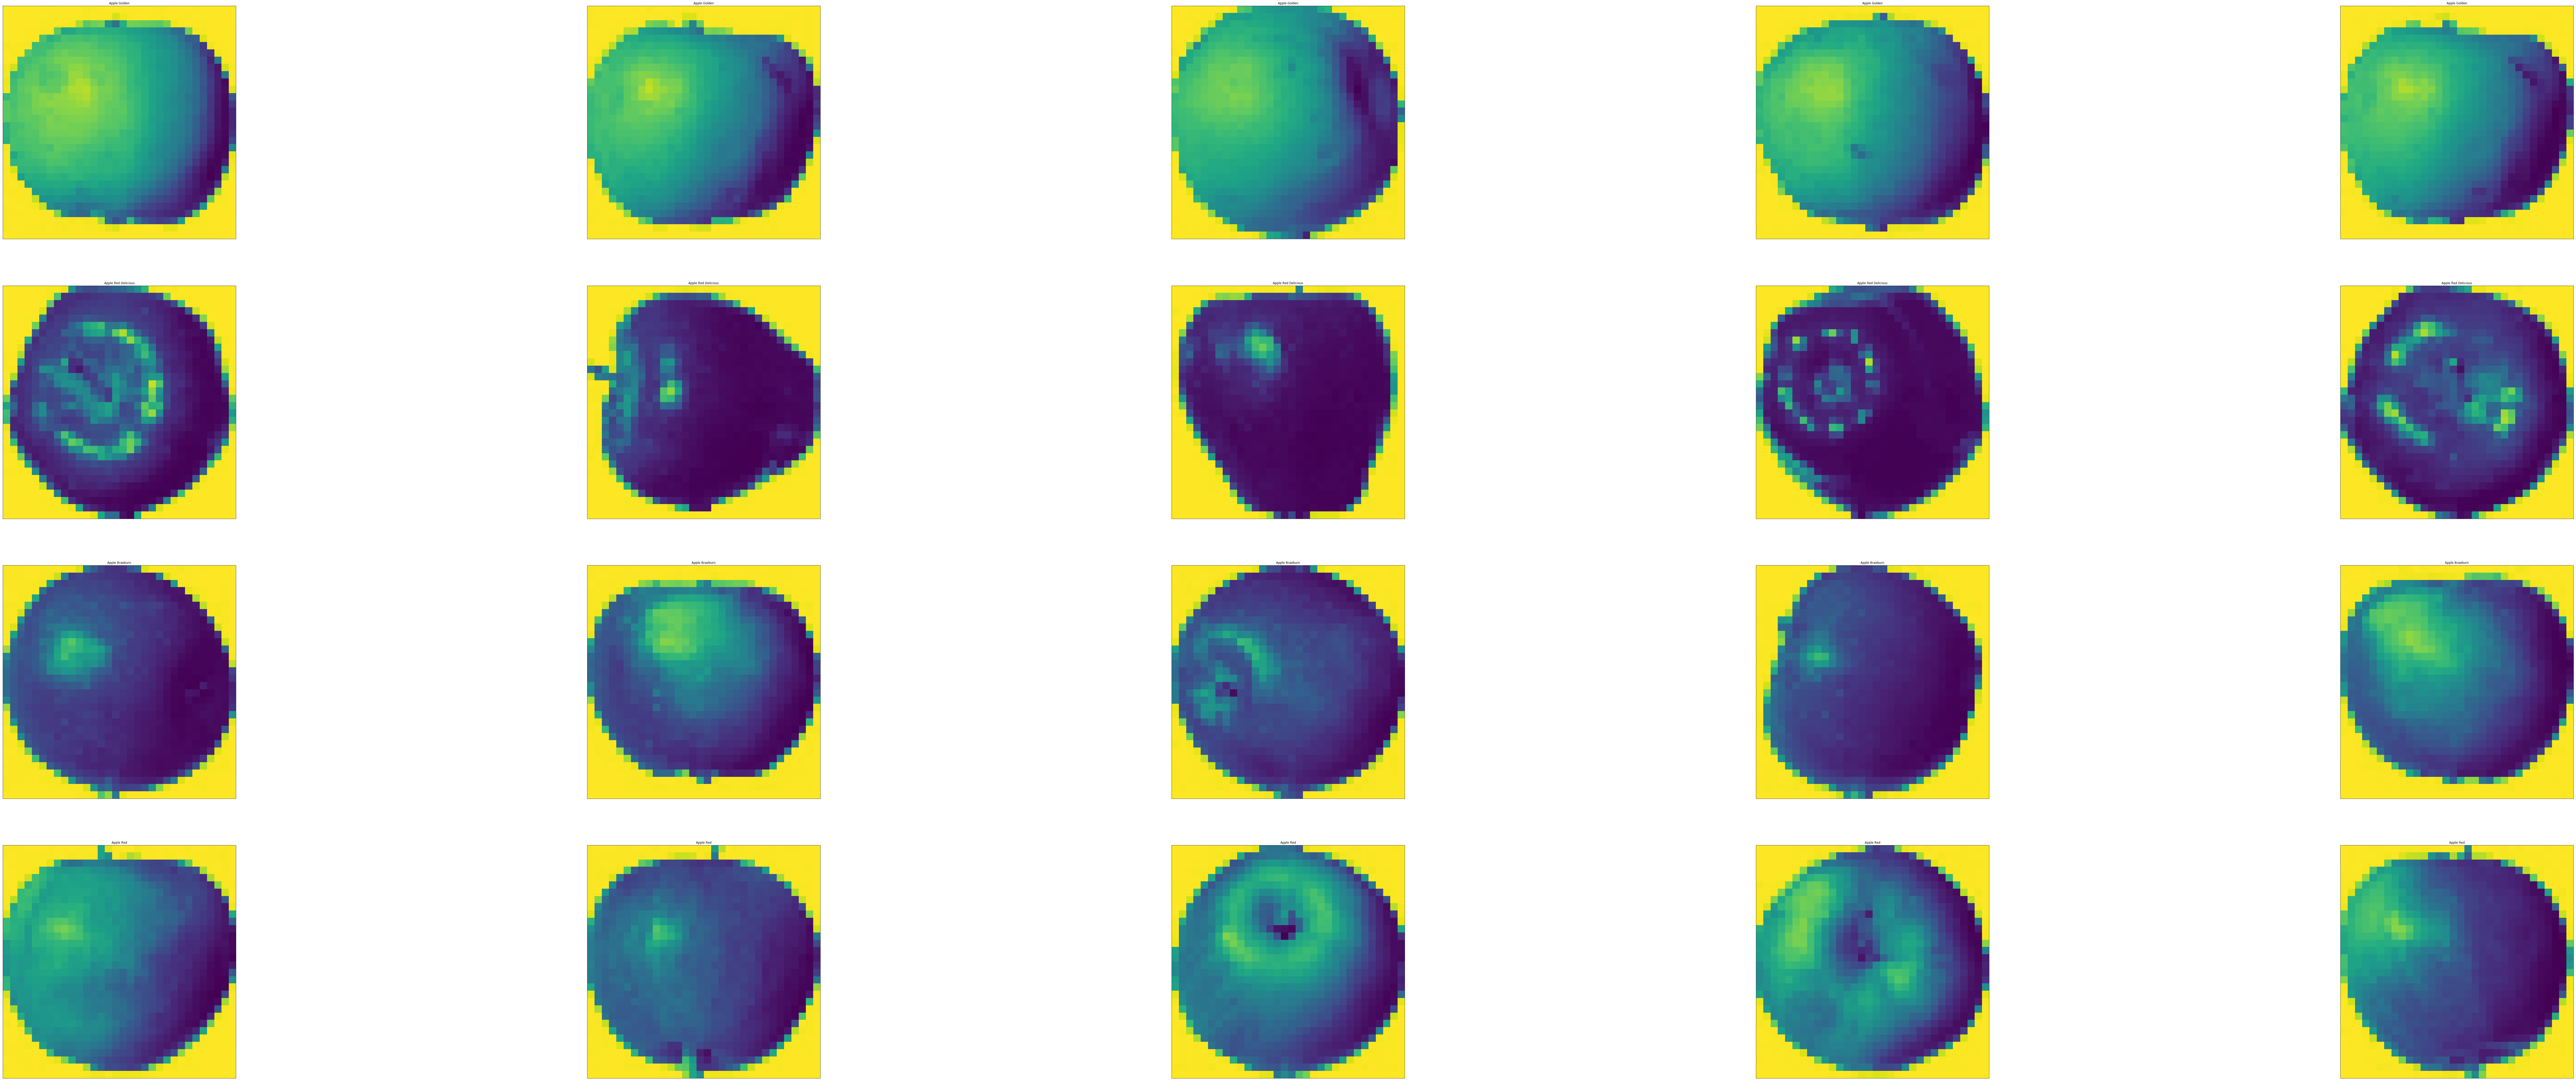

In [8]:
plt.figure(figsize=[200,200])
for i in range(1,1955,100):
    plt.subplot(10,5,i/100 +1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.xticks([]), plt.yticks([]) 

In [9]:
def sub(data):
    data=pd.DataFrame(data,columns=["type"])
    a={'Apple Braeburn':0, 'Apple Golden':1,'Apple Red':2, 'Apple Red Delicious':3}
    data= data["type"].map(a)
    return data.values

In [10]:
y_train=sub(y_train)
y_test=sub(y_test)

In [11]:
x_train=x_train/255
x_test=x_test/255

In [12]:
y_train=y_train.astype("int32")
y_test=y_test.astype("int32")

In [13]:

def cnn_model_fn(features, labels, mode):
    
    input_layer = tf.reshape(features["x"], [-1, 32, 32, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.layers.flatten(pool2)
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=myact)
    
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.45, training=mode == tf.estimator.ModeKeys.TRAIN)
    print (dropout1.shape)
    dense2 = tf.layers.dense(inputs=tf.reshape(dropout1,[-1,1024]), units=1024, activation=myact) 
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=tf.reshape(dropout2,[-1,1024]), units=4)

    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



In [14]:
apple_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/appl_final")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_model_dir': '/tmp/appl_final', '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe650ad5a90>, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_is_chief': True, '_master': '', '_session_config': None, '_save_summary_steps': 100, '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker'}


In [15]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": x_train},
      y=y_train,
      batch_size=100,
      num_epochs=None,shuffle=True)

In [16]:
apple_classifier.train(input_fn=train_input_fn, steps=20000)

<unknown>
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/appl_final/model.ckpt.
INFO:tensorflow:loss = 1.4172559, step = 1
INFO:tensorflow:global_step/sec: 2.2408
INFO:tensorflow:loss = 1.3914022, step = 101 (44.634 sec)
INFO:tensorflow:global_step/sec: 2.27453
INFO:tensorflow:loss = 1.3799429, step = 201 (43.965 sec)
INFO:tensorflow:global_step/sec: 2.27416
INFO:tensorflow:loss = 1.3770096, step = 301 (43.969 sec)
INFO:tensorflow:global_step/sec: 2.13894
INFO:tensorflow:loss = 1.3800472, step = 401 (46.751 sec)
INFO:tensorflow:global_step/sec: 2.22261
INFO:tensorflow:loss = 1.3735402, step = 501 (45.002 sec)
INFO:tensorflow:global_step/sec: 2.18004
INFO:tensorflow:loss = 1.3832138, step = 601 (45.859 sec)
INFO:tensorflow:global_step/sec: 2.30949
INFO:tensorflow:loss = 1.3820881, step = 701 (43.311 sec)
INFO:tensorflow:global_step/sec: 2.30017
INFO:tensorflow:loss = 1.3772107, step = 801 (43.467 sec)
INFO:tensorflow:global_step/sec: 2.148

INFO:tensorflow:global_step/sec: 2.34451
INFO:tensorflow:loss = 0.16969743, step = 7501 (42.658 sec)
INFO:tensorflow:global_step/sec: 2.3427
INFO:tensorflow:loss = 0.100066245, step = 7601 (42.689 sec)
INFO:tensorflow:Saving checkpoints for 7660 into /tmp/appl_final/model.ckpt.
INFO:tensorflow:global_step/sec: 2.35844
INFO:tensorflow:loss = 0.17088357, step = 7701 (42.391 sec)
INFO:tensorflow:global_step/sec: 2.238
INFO:tensorflow:loss = 0.12812777, step = 7801 (44.688 sec)
INFO:tensorflow:global_step/sec: 2.34575
INFO:tensorflow:loss = 0.05911766, step = 7901 (42.627 sec)
INFO:tensorflow:global_step/sec: 2.37714
INFO:tensorflow:loss = 0.0766657, step = 8001 (42.066 sec)
INFO:tensorflow:global_step/sec: 2.37225
INFO:tensorflow:loss = 0.08434957, step = 8101 (42.155 sec)
INFO:tensorflow:global_step/sec: 2.35224
INFO:tensorflow:loss = 0.06591617, step = 8201 (42.525 sec)
INFO:tensorflow:global_step/sec: 2.36113
INFO:tensorflow:loss = 0.15289775, step = 8301 (42.353 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 2.33989
INFO:tensorflow:loss = 0.018630328, step = 15101 (42.734 sec)
INFO:tensorflow:global_step/sec: 2.3736
INFO:tensorflow:loss = 0.02665893, step = 15201 (42.127 sec)
INFO:tensorflow:global_step/sec: 2.38234
INFO:tensorflow:loss = 0.025562473, step = 15301 (41.980 sec)
INFO:tensorflow:global_step/sec: 2.36776
INFO:tensorflow:loss = 0.031391736, step = 15401 (42.228 sec)
INFO:tensorflow:global_step/sec: 2.39745
INFO:tensorflow:loss = 0.028441105, step = 15501 (41.712 sec)
INFO:tensorflow:global_step/sec: 2.35939
INFO:tensorflow:loss = 0.014174294, step = 15601 (42.384 sec)
INFO:tensorflow:global_step/sec: 2.39098
INFO:tensorflow:loss = 0.008035408, step = 15701 (41.823 sec)
INFO:tensorflow:global_step/sec: 2.34086
INFO:tensorflow:loss = 0.021061659, step = 15801 (42.720 sec)
INFO:tensorflow:global_step/sec: 2.37954
INFO:tensorflow:loss = 0.008310953, step = 15901 (42.024 sec)
INFO:tensorflow:global_step/sec: 2.36702
INFO:tensorflow:loss = 0.022365863

In [17]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": x_test},
      y=y_test,
      num_epochs=1,
      shuffle=False)
eval_results = apple_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

<unknown>
INFO:tensorflow:Starting evaluation at 2018-02-08-23:40:01
INFO:tensorflow:Restoring parameters from /tmp/appl_final/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-02-08-23:40:01
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.90839696, global_step = 20000, loss = 0.6171722
{'accuracy': 0.90839696, 'global_step': 20000, 'loss': 0.6171722}
